# Training a simple convolutional neural network for MNIST with Pytorch


In [1]:
import torch
import numpy as np

# Load datasets

In [2]:
from torchvision import datasets
import torchvision.transforms as transforms

# number of subprocesses to use for data loading
num_workers = 0
# how many samples per batch to load
batch_size = 20

# convert data to torch.FloatTensor
transform = transforms.ToTensor()

# choose the training and test datasets
train_data = datasets.MNIST(root='data', train=True,
                                   download=True, transform=transform)
test_data = datasets.MNIST(root='data', train=False,
                                  download=True, transform=transform)

# prepare data loaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
    num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, 
    num_workers=num_workers)

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw




Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw
Processing...
Done!


/Users/chupi/anaconda3/envs/pytorch/lib/python3.7/site-packages/torchvision/datasets/mnist.py:469: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ../torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


# View data

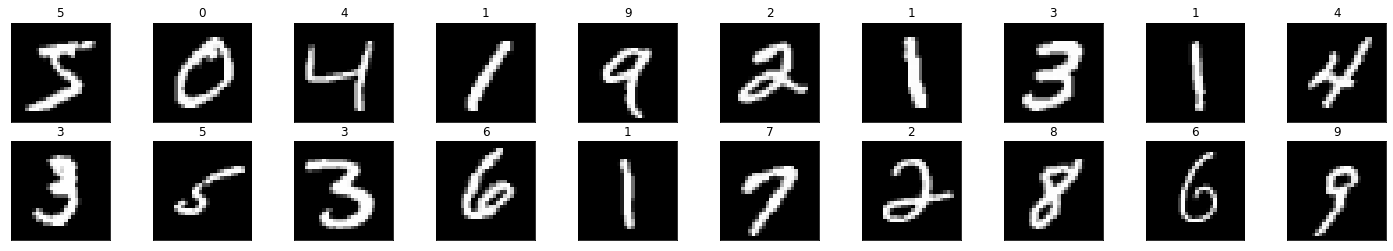

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline
    
# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy()

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    # print out the correct label for each image
    # .item() gets the value contained in a Tensor
    ax.set_title(str(labels[idx].item()))

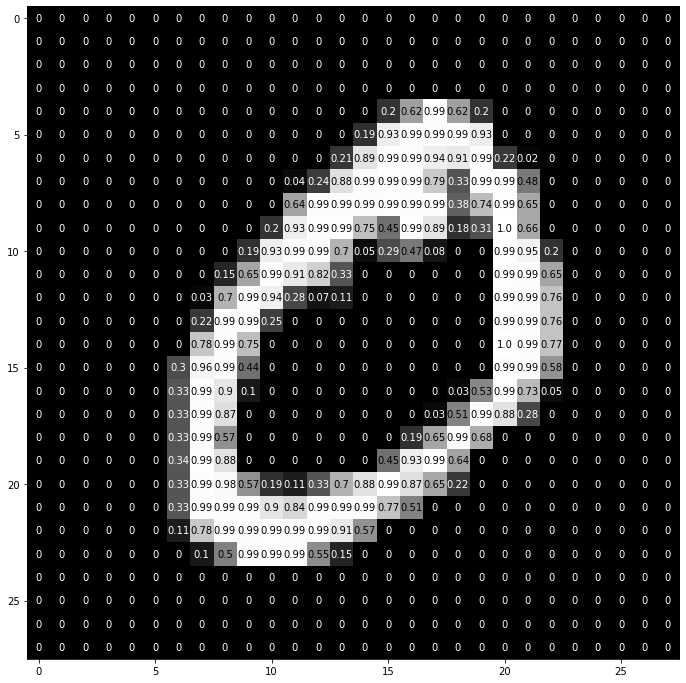

In [4]:
#View an image in more detail
img = np.squeeze(images[1])

fig = plt.figure(figsize = (12,12)) 
ax = fig.add_subplot(111)
ax.imshow(img, cmap='gray')
width, height = img.shape
thresh = img.max()/2.5
for x in range(width):
    for y in range(height):
        val = round(img[x][y],2) if img[x][y] !=0 else 0
        ax.annotate(str(val), xy=(y,x),
                    horizontalalignment='center',
                    verticalalignment='center',
                    color='white' if img[x][y]<thresh else 'black')

# Define the network

In [5]:
import torch.nn as nn
import torch.nn.functional as F

## Define the NN architecture
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=3)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        x = F.log_softmax(x, dim=1)
        return x

# initialize the NN
model = Net()
print(model)

Net(
  (conv1): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2_drop): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=320, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=10, bias=True)
)


In [6]:
## Specify loss and optimization functions

# specify loss function
criterion = nn.CrossEntropyLoss()

# specify optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

In [7]:
# number of epochs to train the model
n_epochs = 5  # suggest training between 20-50 epochs

model.train() # prep model for training

for epoch in range(n_epochs):
    # monitor training loss
    train_loss = 0.0
    
    ###################
    # train the model #
    ###################
    for data, target in train_loader:
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update running training loss
        train_loss += loss.item()*data.size(0)
        
    # print training statistics 
    # calculate average loss over an epoch
    train_loss = train_loss/len(train_loader.dataset)

    print('Epoch: {} \tTraining Loss: {:.6f}'.format(
            epoch+1, 
            train_loss
        ))

Epoch: 1 	Training Loss: 1.075308
Epoch: 2 	Training Loss: 0.432949
Epoch: 3 	Training Loss: 0.335705
Epoch: 4 	Training Loss: 0.297292
Epoch: 5 	Training Loss: 0.269477


# Test the trained network

In [8]:
# initialize lists to monitor test loss and accuracy
test_loss = 0.0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

model.eval() # prep model for *evaluation*

for data, target in test_loader:
    # forward pass: compute predicted outputs by passing inputs to the model
    output = model(data)
    # calculate the loss
    loss = criterion(output, target)
    # update test loss 
    test_loss += loss.item()*data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)
    # compare predictions to true label
    correct = np.squeeze(pred.eq(target.data.view_as(pred)))
    # calculate test accuracy for each object class
    for i in range(batch_size):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

# calculate and print avg test loss
test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(10):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            str(i), 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 0.090183

Test Accuracy of     0: 98% (968/980)
Test Accuracy of     1: 99% (1125/1135)
Test Accuracy of     2: 97% (1004/1032)
Test Accuracy of     3: 95% (966/1010)
Test Accuracy of     4: 97% (955/982)
Test Accuracy of     5: 98% (878/892)
Test Accuracy of     6: 97% (934/958)
Test Accuracy of     7: 95% (982/1028)
Test Accuracy of     8: 95% (927/974)
Test Accuracy of     9: 95% (964/1009)

Test Accuracy (Overall): 97% (9703/10000)


# Visualize sample test results

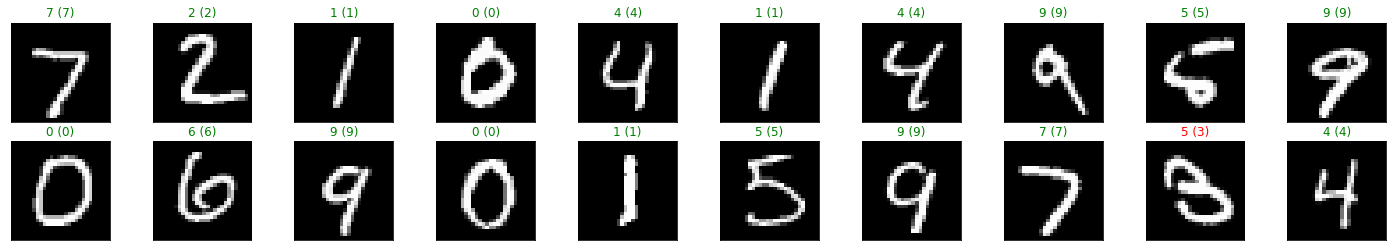

In [9]:
# obtain one batch of test images
dataiter = iter(test_loader)
images, labels = dataiter.next()

# get sample outputs
output = model(images)
# convert output probabilities to predicted class
_, preds = torch.max(output, 1)
# prep images for display
images = images.numpy()

# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    ax.set_title("{} ({})".format(str(preds[idx].item()), str(labels[idx].item())),
                 color=("green" if preds[idx]==labels[idx] else "red"))

# Saving model

In [10]:
torch.save(model, 'mnist_conv_model.pth')

# Model `state_dict'

In [11]:
# Print model's state_dict
print("Model's state_dict:")
for param_tensor in model.state_dict():
    print(param_tensor, "\t", model.state_dict()[param_tensor].size())

# Print optimizer's state_dict
print("Optimizer's state_dict:")
for var_name in optimizer.state_dict():
    print(var_name, "\t", optimizer.state_dict()[var_name])

Model's state_dict:
conv1.weight 	 torch.Size([10, 1, 3, 3])
conv1.bias 	 torch.Size([10])
conv2.weight 	 torch.Size([20, 10, 5, 5])
conv2.bias 	 torch.Size([20])
fc1.weight 	 torch.Size([50, 320])
fc1.bias 	 torch.Size([50])
fc2.weight 	 torch.Size([10, 50])
fc2.bias 	 torch.Size([10])
Optimizer's state_dict:
state 	 {}
param_groups 	 [{'lr': 0.01, 'momentum': 0, 'dampening': 0, 'weight_decay': 0, 'nesterov': False, 'params': [0, 1, 2, 3, 4, 5, 6, 7]}]


# Obtain the weights of convolutional filters

In [12]:
sd = model.state_dict()

In [13]:
sd.keys()

odict_keys(['conv1.weight', 'conv1.bias', 'conv2.weight', 'conv2.bias', 'fc1.weight', 'fc1.bias', 'fc2.weight', 'fc2.bias'])

In [15]:
conv1_layer = sd['conv1.weight']

In [16]:
conv1_layer.shape

torch.Size([10, 1, 3, 3])

In [17]:
conv2_layer = sd['conv2.weight']
conv2_layer.shape

torch.Size([20, 10, 5, 5])

In [29]:
#note the dimension of the filters

In [18]:
import numpy as np

In [19]:
#tensor to matrix
conv1_layer = conv1_layer.numpy()

In [20]:
filters = np.squeeze(conv1_layer)
filters.shape

(10, 3, 3)

In [21]:
f1 = filters[0]

In [22]:
f1

array([[-0.2902132 , -0.4544834 , -0.41983986],
       [ 0.17369343,  0.20413451,  0.2467371 ],
       [ 0.47885725,  0.3265251 ,  0.3012395 ]], dtype=float32)

In [23]:
import cv2

In [24]:
#save image to file
img = np.squeeze(images[1])*255
type(img)

numpy.ndarray

In [25]:
cv2.imwrite('two.png', img)

True

In [26]:
img

array([[  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 116.,
        125., 171., 255., 255., 150.,  93.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 169., 253.,
        253., 253., 253., 253., 253., 218.,  30.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   0.,   0

In [27]:
#convo with filter
kernel = f1
out_img = cv2.filter2D(img, -1, kernel)

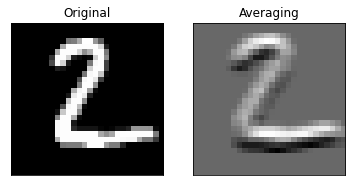

In [28]:
plt.subplot(121),plt.imshow(img, cmap='gray'),plt.title('Original')
plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(out_img, cmap='gray'),plt.title('Averaging')
plt.xticks([]), plt.yticks([])
plt.show()

# Visualize all filters

In [29]:
all_filters = {}
for layer in ['conv1.weight', 'conv2.weight']:
    tensor = model.state_dict()[layer]
    kernel_size = tensor.shape[-1]
    filters = model.state_dict()[layer].flatten().view(-1, kernel_size, kernel_size).numpy()
    print("Shape of conv layer: ", filters.shape)
    for i, kernel in enumerate(filters):
        all_filters[f'{layer}_{i}'] = kernel

Shape of conv layer:  (10, 3, 3)
Shape of conv layer:  (200, 5, 5)


In [30]:
len(all_filters)

210

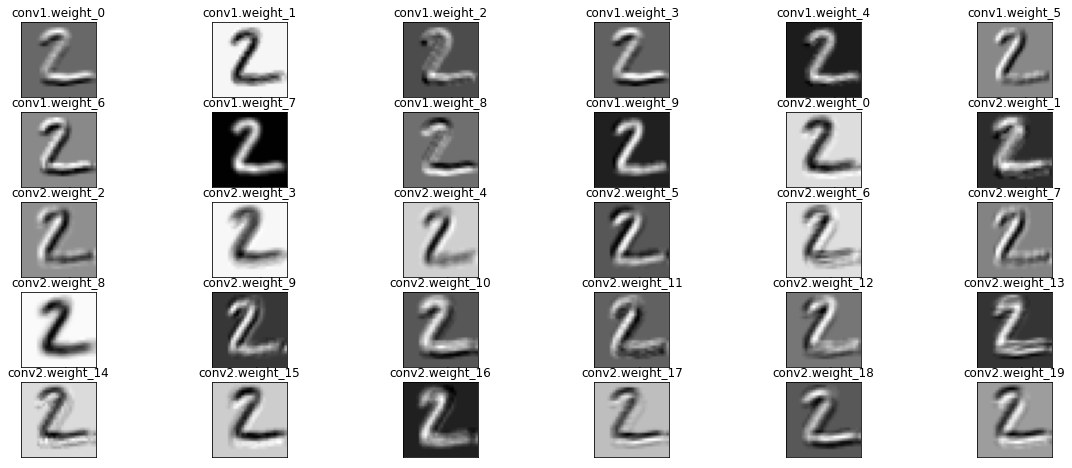

In [31]:
#print first 30 kernels
plt.figure(figsize=(20, 8))
i = 1
for key, kernel in all_filters.items():
    if i>30:
        break
    
    dst = cv2.filter2D(img, -1, kernel)
    
    plt.subplot(5, 6, i)
    plt.imshow(dst, cmap='gray')
    plt.title(key)
    plt.xticks([]), plt.yticks([])
    i += 1

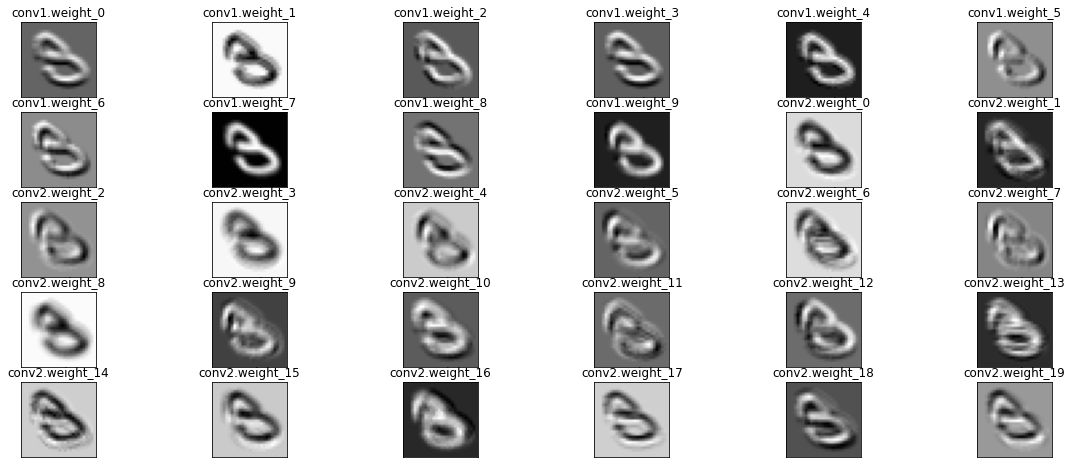

In [32]:
#print first 30 kernels for another image
img = np.squeeze(images[18])*255

plt.figure(figsize=(20, 8))
i = 1
for key, kernel in all_filters.items():
    if i>30:
        break
    
    dst = cv2.filter2D(img, -1, kernel)
    
    plt.subplot(5, 6, i)
    plt.imshow(dst, cmap='gray')
    plt.title(key)
    plt.xticks([]), plt.yticks([])
    i += 1

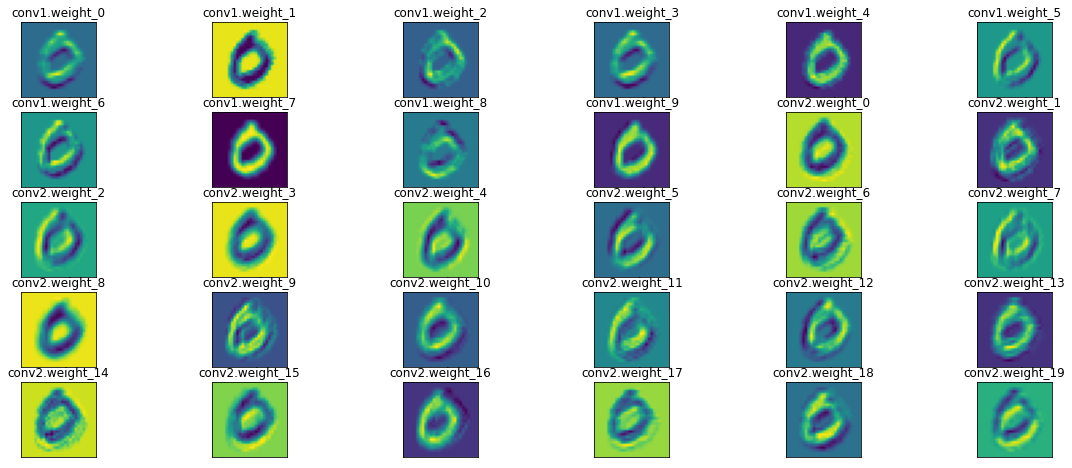

In [33]:
#print first 30 kernels for another image
img = np.squeeze(images[3])*255

plt.figure(figsize=(20, 8))
i = 1
for key, kernel in all_filters.items():
    if i>30:
        break
    
    dst = cv2.filter2D(img, -1, kernel)
    
    plt.subplot(5, 6, i)
    plt.imshow(dst)
    plt.title(key)
    plt.xticks([]), plt.yticks([])
    i += 1